In [32]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools

# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matemáticos para aproximar una función de valor. Al utilizar este tipo de herramientas, aumentamos el riesgo de ver un comportamiento inestable y divergente durante el entrenamiento del agente. Esto se da por la presencia de tres aspectos principales, llamados 'Triada Mortal':

* Aproximación de funciones: es una forma poderosa y escalable de generalizar desde un espacio de estado mucho más grande que la memoria y los recursos computacionales (por ejemplo, aproximación de función lineal o Redes Neuronales Artificiales).

* Bootstrapping: se actualizan objetivos que son dependientes de las estimaciones existentes (por ejemplo, en los métodos de TD) en lugar de depender exclusivamente de las recompensas reales (como en aprendizaje supervisado).

* Off-Policy: Entrenamiento de un agente en base a una política diferente a la política objetivo (Por ejemplo Q-Learning).

## CartPole: Agente aleatorio
CartPole es un entorno donde un poste está unido por una unión no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical, y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanezca en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical, o el carro se mueve más de 2.4 unidades desde el centro.

In [2]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementación de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Un gran problema en el uso de aproximadores para la función de valor $Q$, es que las transiciones (la experiencia del agente) están muy correlacionadas. Esto reduce la varianza general de cada transición y disminuye la capacidad de generalizacion del predictor. 
Imaginemos que tuviéramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

Para solucionar este problema, el equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en una memoria de experiencia y después de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria.

In [82]:
class LinearModel(nn.Module):

    def __init__(self, _input_size: int, _output_size: int):
        super(LinearModel, self).__init__()       
        self.output = nn.Linear(_input_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.output(x)
        return x

In [108]:
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from agents.utils.memory.ReplayMemory import ReplayMemory
from agents.utils.memory.Transition import Transition

class LinearCartPoleSolver:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = LinearModel(self.observation_space_size, self.action_space_size).to(self.device)        
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor before
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()
                state = next_state

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [109]:
agent = LinearCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresLineal, meanLineal = agent.run()

[Episode 0] - Mean reward 53.0.
[Episode 100] - Mean reward 42.40594059405941.
[Episode 200] - Mean reward 32.46766169154229.
[Episode 300] - Mean reward 28.368770764119603.
[Episode 400] - Mean reward 25.865336658354114.
[Episode 500] - Mean reward 24.714570858283434.
[Episode 600] - Mean reward 24.655574043261232.
[Episode 700] - Mean reward 24.884450784593437.
[Episode 800] - Mean reward 23.802746566791512.
[Episode 900] - Mean reward 23.533851276359602.
[Episode 1000] - Mean reward 22.664335664335663.
[Episode 1100] - Mean reward 22.396911898274297.
[Episode 1200] - Mean reward 21.83347210657785.
[Episode 1300] - Mean reward 21.90468870099923.
[Episode 1400] - Mean reward 21.602426837972878.
[Episode 1500] - Mean reward 21.249167221852097.
[Episode 1600] - Mean reward 21.519050593379138.
[Episode 1700] - Mean reward 21.0135214579659.
[Episode 1800] - Mean reward 20.523042754025543.
[Episode 1900] - Mean reward 20.07890583903209.
[Episode 2000] - Mean reward 19.777611194402798.
[Epi

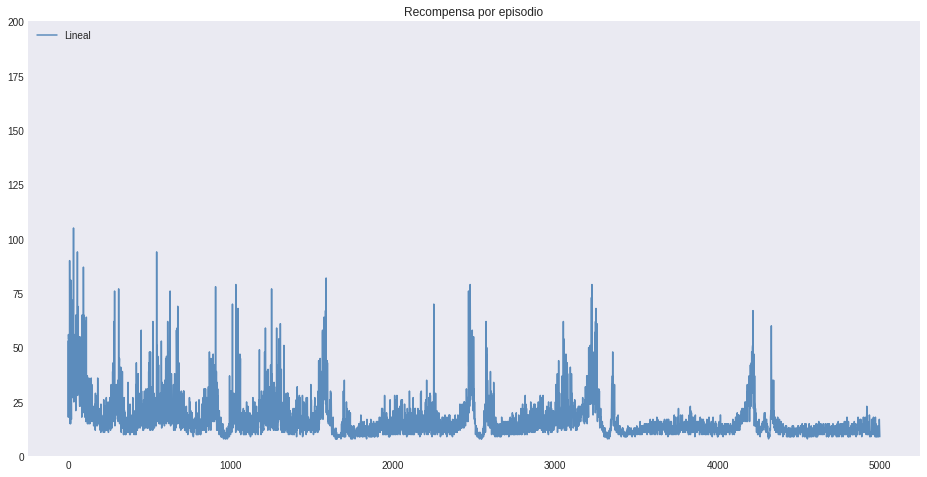

In [110]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

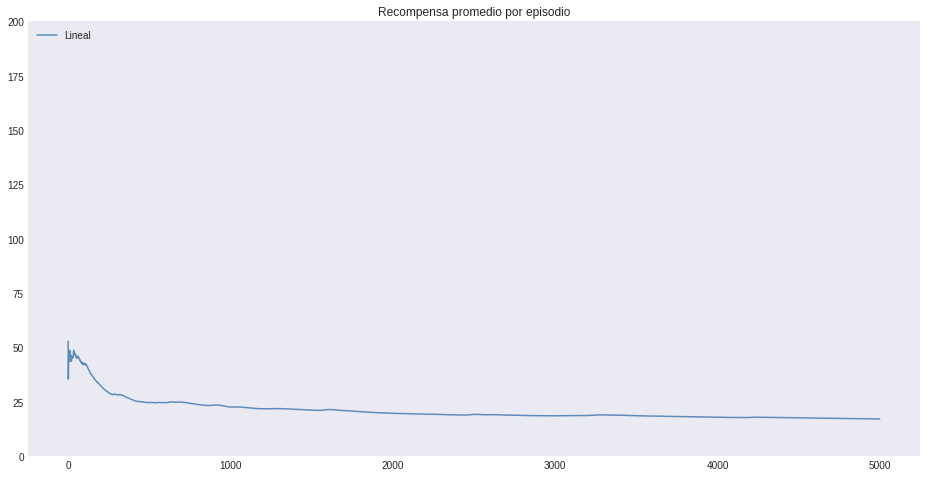

In [111]:
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo que tiene estados con dos dimensiones numéricas. Para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$. Se puede elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$, pero así, no se puede tener en cuenta ninguna interacción entre estas dimensiones. Además, si tanto $s_1$ como $s_2$ son cero, entonces el valor aproximado también será cero ($x(s)=0$). Ambas limitaciones se pueden superar representando $s$ por el vector de features polinomico $x(s)=(1,s_1,s_2,s_1s_2)$. El 1 inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s1s2$, permite que se tengan en cuenta dichas interacciones. También se puede utilizar un vector de features polinomico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciones mas complejas.

En el caso del entorno CartPole, un predictor lineal que tenga como input unicamente las variables que el entorno emite no puede modelar la relacion entre la posición y velocidad del carro con respecto al angulo y velocidad del poste.

In [112]:
class PolyCartPoleSolver:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.feature_tuning = PolynomialFeatures(interaction_only=True)
        # Initialize feature tunning
        self.feature_tuning.fit(self.env.reset().reshape((1, 4)))

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def preprocess_state(self, state):
        """State and action are stacked horizontally and its features are combined as a polynomial to be passed as an
        input of the approximator"""

        # poly_state converts the horizontal stack into a combination of its parameters i.e.
        # [1, s_1, s_2, s_3, s_4, a_1, s_1 s_2, s_1 s_3, ...]
        poly_state = self.feature_tuning.transform(state.reshape((1, 4)))
        return poly_state[0]

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(self.preprocess_state(state), device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(self.preprocess_state(next_state), device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  # Converted to tensor before
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()
                state = next_state

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [113]:
agent = PolyCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresPoly, meanPoly = agent.run()

[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 12.673267326732674.
[Episode 200] - Mean reward 11.587064676616915.
[Episode 300] - Mean reward 11.295681063122924.
[Episode 400] - Mean reward 11.271820448877806.
[Episode 500] - Mean reward 11.72055888223553.
[Episode 600] - Mean reward 12.582362728785357.
[Episode 700] - Mean reward 13.780313837375179.
[Episode 800] - Mean reward 16.17478152309613.
[Episode 900] - Mean reward 20.16315205327414.
[Episode 1000] - Mean reward 24.513486513486512.
[Episode 1100] - Mean reward 30.33514986376022.
[Episode 1200] - Mean reward 33.91257285595337.
[Episode 1300] - Mean reward 36.996156802459645.
[Episode 1400] - Mean reward 39.940042826552464.
[Episode 1500] - Mean reward 43.989340439706865.
[Episode 1600] - Mean reward 46.74515927545284.
[Episode 1700] - Mean reward 55.54908877131099.
[Episode 1800] - Mean reward 62.46141032759578.
[Episode 1900] - Mean reward 66.16465018411363.
[Episode 2000] - Mean reward 70.20089955022489.
[Episod

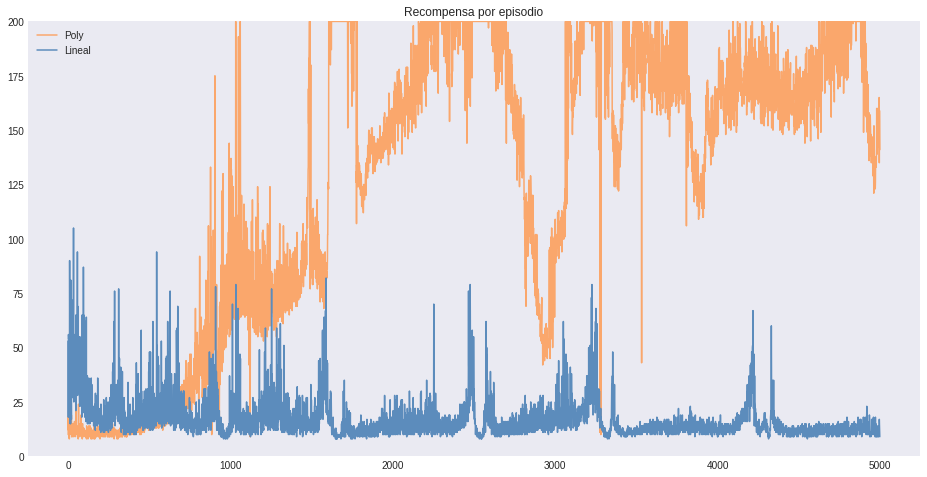

In [114]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

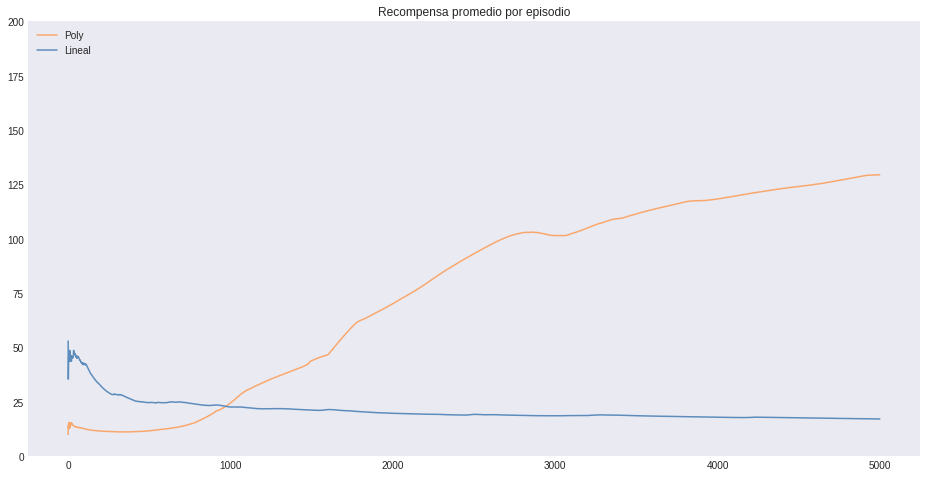

In [115]:
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación actual ($w_{t}$). Donde el objetivo ($w_{t+1}$), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_{t}$ puede conducir a oscilaciones y/o divergencias en el entrenamiento del predictor.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solución para acercar el proceso de actualización de los parámetros ($w_t$) de un estimador, a un formato similar al utilizado en el aprendizaje supervisado. Esto es, se utiliza otro modelo predictivo $\tilde{q}$ como objetivo en la actualización de los pesos $w$ del estimador $\hat{q}$. Cada vez que se realizan un cierto número $C$ de actualizaciones de los pesos $w$ en el predictor $\hat{q}$, se realiza una copia de los mismos en el otro modelo $\tilde{q}$ donde se mantienen estos pesos duplicados de forma fija para las próximas $C$ actualizaciones de $w$.

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [116]:
class PolyDualCartPoleSolver:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.01, epsilon_log_decay=0.005, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, render=False, debug=False):
        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.feature_tuning = PolynomialFeatures(interaction_only=True)
        # Initialize feature tunning
        self.feature_tuning.fit(self.env.reset().reshape((1, 4)))

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.model.train()
        self.target = LinearModel(self.feature_tuning.n_output_features_, self.action_space_size).to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def preprocess_state(self, state):
        """State and action are stacked horizontally and its features are combined as a polynomial to be passed as an
        input of the approximator"""

        # poly_state converts the horizontal stack into a combination of its parameters i.e.
        # [1, s_1, s_2, s_3, s_4, a_1, s_1 s_2, s_1 s_3, ...]
        poly_state = self.feature_tuning.transform(state.reshape((1, 4)))
        return poly_state[0]

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(self.preprocess_state(state), device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(self.preprocess_state(next_state), device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  # Converted to tensor before
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()
                state = next_state
                j += 1
                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)

In [117]:
agent = PolyDualCartPoleSolver(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresPolyDual, meanPolyDual = agent.run()

[Episode 0] - Mean reward 10.0.
[Episode 100] - Mean reward 11.782178217821782.
[Episode 200] - Mean reward 11.432835820895523.
[Episode 300] - Mean reward 11.23920265780731.
[Episode 400] - Mean reward 11.72069825436409.
[Episode 500] - Mean reward 13.081836327345309.
[Episode 600] - Mean reward 16.346089850249584.
[Episode 700] - Mean reward 22.606276747503568.
[Episode 800] - Mean reward 25.52059925093633.
[Episode 900] - Mean reward 33.445061043285236.
[Episode 1000] - Mean reward 37.96203796203796.
[Episode 1100] - Mean reward 41.35603996366939.
[Episode 1200] - Mean reward 44.33555370524563.
[Episode 1300] - Mean reward 46.72867025365104.
[Episode 1400] - Mean reward 48.79871520342613.
[Episode 1500] - Mean reward 50.66155896069287.
[Episode 1600] - Mean reward 52.41911305434104.
[Episode 1700] - Mean reward 57.686067019400355.
[Episode 1800] - Mean reward 65.1399222654081.
[Episode 1900] - Mean reward 72.20252498684903.
[Episode 2000] - Mean reward 77.30384807596202.
[Episode 21

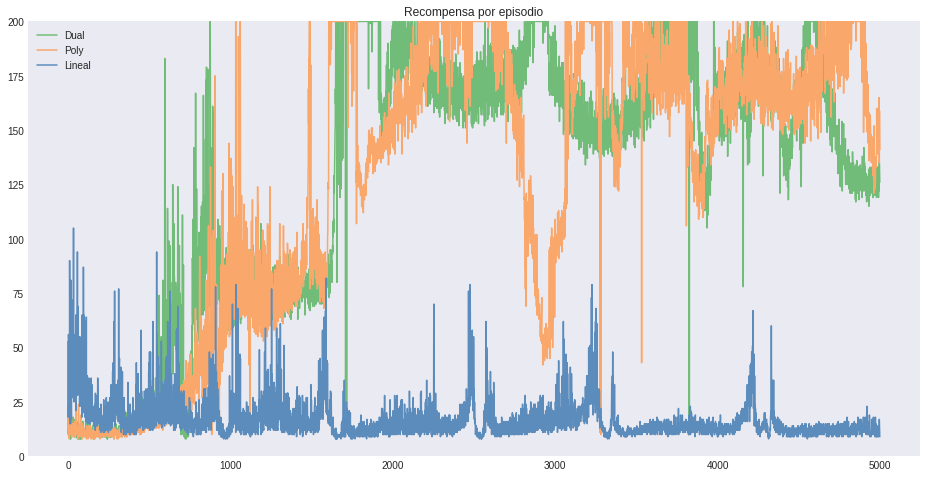

In [118]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

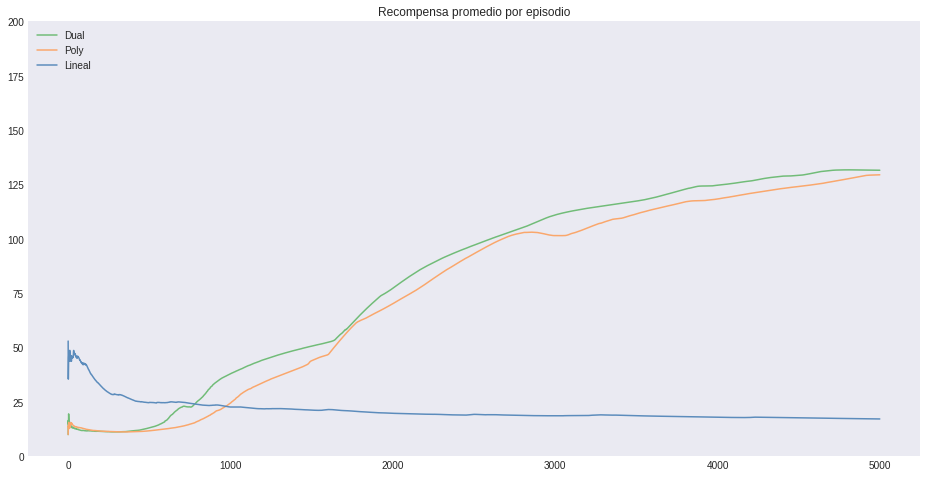

In [119]:
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales
Como ultima mejora, vamos a reemplazar el aproximador lineal por una red neuronal. En este caso, estamos trabajando con un entorno donde directamente el agente percibe los features que representan el estado del mismo. Por lo tanto, utilizaremos una red neuronal 'fully connected' de 3 capas con la siguiente arquitectura:

![nn_dense](images/nn_dense.png)

En este caso, como el aproximador usado es 'no lineal', no tenemos necesidad de hacer un pre-prosesamiento de los features, como en el caso del agente 'SGD_Poly' y 'SGD_Poly_Dual', para poder capturar las relaciones no lineales entre los distintos features del entorno.

### Funciones de activación:
![activation_functions](images/activation_functions.png)

In [120]:
class Net(nn.Module):

    def __init__(self, _input_size: int, _output_size: int, _hidden_layers: int, _hidden_size: int):
        super(Net, self).__init__()
        self.input = nn.Linear(_input_size, _hidden_size)
        self.hidden_layers = _hidden_layers
        self.hidden = []
        for i in range(_hidden_layers):
            layer = nn.Linear(_hidden_size, _hidden_size)
            self.add_module('h'+str(i), layer)
            self.hidden.append(layer)
        self.output = nn.Linear(_hidden_size, _output_size)

        # init weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.input(x))
        for i in range(self.hidden_layers):
            x = F.relu(self.hidden[i](x))
        x = self.output(x)
        return x

In [125]:
class DQN:
    def __init__(self, env, n_episodes=3000, max_env_steps=None, gamma=0.9,
                 epsilon=0.5, epsilon_min=0.05, epsilon_log_decay=0.001, alpha=1e-3,
                 memory_size=10000, batch_size=256, c=10, hidden_layers=2, hidden_size=24,
                 render=False, debug=False):

        self.memory = ReplayMemory(capacity=memory_size)
        self.env = env

        # hyper-parameter setting
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.c = c
        if max_env_steps is not None:
            self.env._max_episode_steps = max_env_steps
        self.observation_space_size = env.observation_space.shape[0]
        self.action_space_size = env.action_space.n

        self.render = render
        self.debug = debug
        if debug:
            self.loss_list = []
        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Init model 1
        # Use the nn package to define our model as a sequence of layers. nn.Sequential
        # is a Module which contains other Modules, and applies them in sequence to
        # produce its output. Each Linear Module computes output from input using a
        # linear function, and holds internal Tensors for its weight and bias.
        # After constructing the model we use the .to() method to move it to the
        # desired device.
        self.model = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target = Net(self.observation_space_size, self.action_space_size, hidden_layers, hidden_size) \
            .to(self.device)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        self.model.train()

        # The nn package also contains definitions of popular loss functions; in this
        # case we will use Mean Squared Error (MSE) as our loss function. Setting
        # reduction='sum' means that we are computing the *sum* of squared errors rather
        # than the mean; this is for consistency with the examples above where we
        # manually compute the loss, but in practice it is more common to use mean
        # squared error as a loss by setting reduction='elementwise_mean'.
        self.loss_fn = torch.nn.MSELoss()

        # Use the optim package to define an Optimizer that will update the weights of
        # the model for us. Here we will use Adam; the optim package contains many other
        # optimization algoriths. The first argument to the Adam constructor tells the
        # optimizer which Tensors it should update.
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=alpha)

    def choose_action(self, state, epsilon):
        """Chooses the next action according to the model trained and the policy"""

        # exploits the current knowledge if the random number > epsilon, otherwise explores
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.model(state)
                argmax = torch.argmax(q)
                return argmax.item()

    def get_epsilon(self, episode):
        """Returns an epsilon that decays over time until a minimum epsilon value is reached; in this case the minimum
        value is returned"""
        return max(self.epsilon_min, self.epsilon * math.exp(-self.epsilon_decay * episode))

    def replay(self):
        """Previously stored (s, a, r, s') tuples are replayed (that is, are added into the model). The size of the
        tuples added is determined by the batch_size parameter"""

        transitions, _ = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

        non_final_mask = torch.stack(batch.done)
        state_batch = torch.stack(batch.state)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.stack(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        with torch.no_grad():
            next_state_values = torch.zeros(self.batch_size, device=self.device)
            next_state_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
            # Compute the expected Q values
            expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute loss
        loss = self.loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

        if self.debug:
            self.loss_list.append(loss)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def run(self):
        """Main loop that controls the execution of the agent"""

        scores = []
        mean_scores = []
        j = 0  # used for model2 update every c steps
        for e in range(self.n_episodes):
            state = self.env.reset()
            state = torch.tensor(state, device=self.device, dtype=torch.float)
            done = False
            cum_reward = 0
            while not done:
                action = self.choose_action(
                    state,
                    self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float)

                cum_reward += reward
                self.memory.push(
                    state,  #Converted to tensor in choose_action method
                    torch.tensor([action], device=self.device),
                    None if done else next_state,
                    torch.tensor(reward, device=self.device).clamp_(-1, 1),
                    torch.tensor(not done, device=self.device, dtype=torch.bool))

                if self.memory.__len__() >= self.batch_size:
                    self.replay()

                state = next_state
                j += 1

                # update second model
                if j % self.c == 0:
                    self.target.load_state_dict(self.model.state_dict())
                    self.target.eval()

            scores.append(cum_reward)
            mean_score = np.mean(scores)
            mean_scores.append(mean_score)
            if e % 100 == 0 and self.debug:
                print('[Episode {}] - Mean reward {}.'.format(e, mean_score))

        # noinspection PyUnboundLocalVariable
        print('[Episode {}] - Mean reward {}.'.format(e, mean_score))
        return scores, mean_scores

    def save(self, path):
        torch.save(self.model, path)

    def load(self, path):
        self.model = torch.load(path)


In [126]:
agent = DQN(gym.make('CartPole-v0'), n_episodes=5000, debug=True)
scoresDQN, meanDQN = agent.run()

[Episode 0] - Mean reward 92.0.
[Episode 100] - Mean reward 82.12871287128714.
[Episode 200] - Mean reward 69.7412935323383.
[Episode 300] - Mean reward 61.352159468438536.
[Episode 400] - Mean reward 55.64339152119701.
[Episode 500] - Mean reward 52.74451097804391.
[Episode 600] - Mean reward 51.20299500831947.
[Episode 700] - Mean reward 51.57774607703281.
[Episode 800] - Mean reward 51.52059925093633.
[Episode 900] - Mean reward 52.730299667036626.
[Episode 1000] - Mean reward 54.52947052947053.
[Episode 1100] - Mean reward 56.12624886466848.
[Episode 1200] - Mean reward 57.678601165695255.
[Episode 1300] - Mean reward 58.83935434281322.
[Episode 1400] - Mean reward 60.48394004282655.
[Episode 1500] - Mean reward 63.50299800133244.
[Episode 1600] - Mean reward 65.56402248594628.
[Episode 1700] - Mean reward 68.3556731334509.
[Episode 1800] - Mean reward 70.69516935036091.
[Episode 1900] - Mean reward 72.90741714886902.
[Episode 2000] - Mean reward 75.70764617691154.
[Episode 2100] -

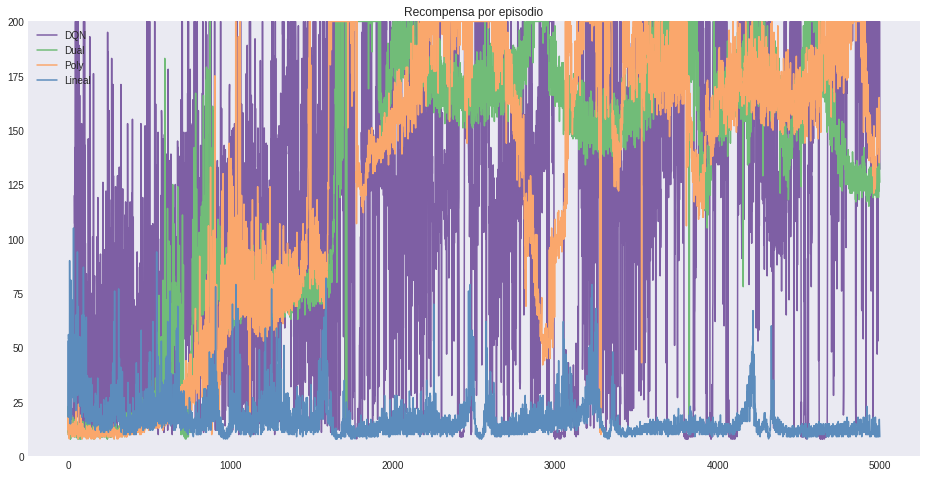

In [123]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(scoresDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(scoresPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(scoresPoly), label='Poly', c='#faa76c')
plt.plot(np.array(scoresLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

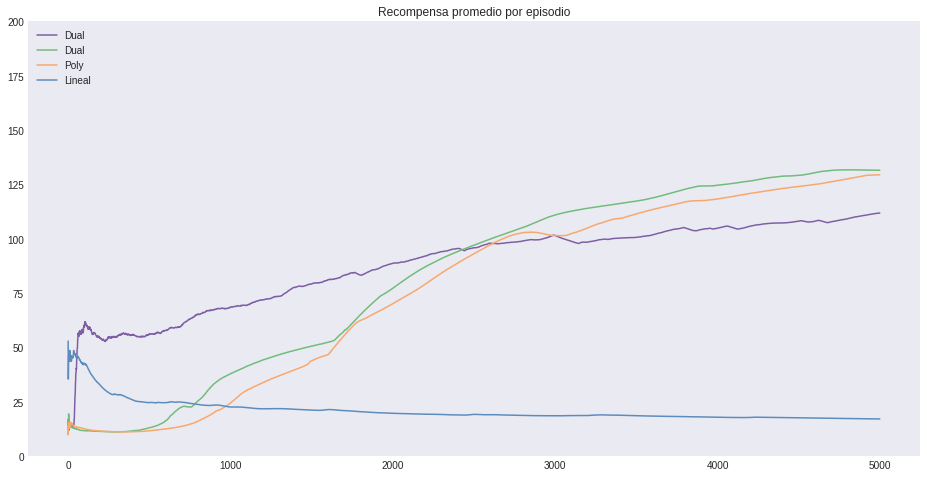

In [124]:
plt.plot(np.array(meanDQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(meanPolyDual), label='Dual', c='#71bc78')
plt.plot(np.array(meanPoly), label='Poly', c='#faa76c')
plt.plot(np.array(meanLineal), label='Lineal', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## Ejercicios Lab Final

Se pide:

1) Implementar [Double DQN (DDQN)](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12389/11847).

2) Implementar [Dueling DDQN](https://arxiv.org/pdf/1511.06581.pdf).

3) Cambiar el entorno por uno nuevo a elección

4) Implementar [Prioritized Experience Replay (PER)](https://arxiv.org/pdf/1511.05952.pdf) (**Opcional**).

**Comentar en un notebook lo realizado paso a paso, mostrando resultados parciales y finales. Y subirlo a un repositorio en GitHub** 

**Recomendación General**: No se sugiere hacer este TP desde jupyter notebook/lab sino desde un IDE estilo "Pycharm" o "Visual Studio Code", debido a que los algoritmos de RL suelen requerir un debug paso a paso, tanto para corregir errores como para entender mejor cómo funcionan los mismos.

**Opcional**: Implementación de un agente DQN convolucional que aprende a jugar a Atari© Space Invaders© ([link](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb))